# Entity Resolution using FuzzyMatch Demo
---
This notebook uses [pyTigerGraph](https://pytigergraph.github.io/pyTigerGraph/), a TigerGraph python interface to run gsql queries on a remote server running TigerGraph via Rest APIs.


### Setup
---
Boilerplate module imports

In [1]:
import time
import random as rand
from pathlib import Path, PurePosixPath
import pyTigerGraph as tg

#### Login Setup
Provide the remote TigerGraph server URL/IP address/hostname and credentials for a TigerGraph user. 

**NOTE**: The TigerGraph user should be created on the server side before proceeding

In [2]:
hostName = "localhost"                              # TG server hostname
userName = "tigergraph"                             # TG user name
passWord = "Xilinx123"                             # TG user password

#### Path Setup
**Local**: Location of query files under the Xilinx graphanalytics github repo. Set location of the local repo.

In [3]:
localRepoLocation = Path("/opt/xilinx/apps")
exampleLocation = Path("graphanalytics/integration/Tigergraph-3.x/fuzzymatch/0.2/examples/entity-resolution") # when running from github repo
queryFileLocation = localRepoLocation / exampleLocation / "query"


**Remote**: Location of input data on the server. **NOTE**: Data should exist on the TigerGraph server 

#### Demo Details 
This demo performs Entity Resolution on new addition of records to the exsisting database, the output of which is a score which gives an indication of the match.


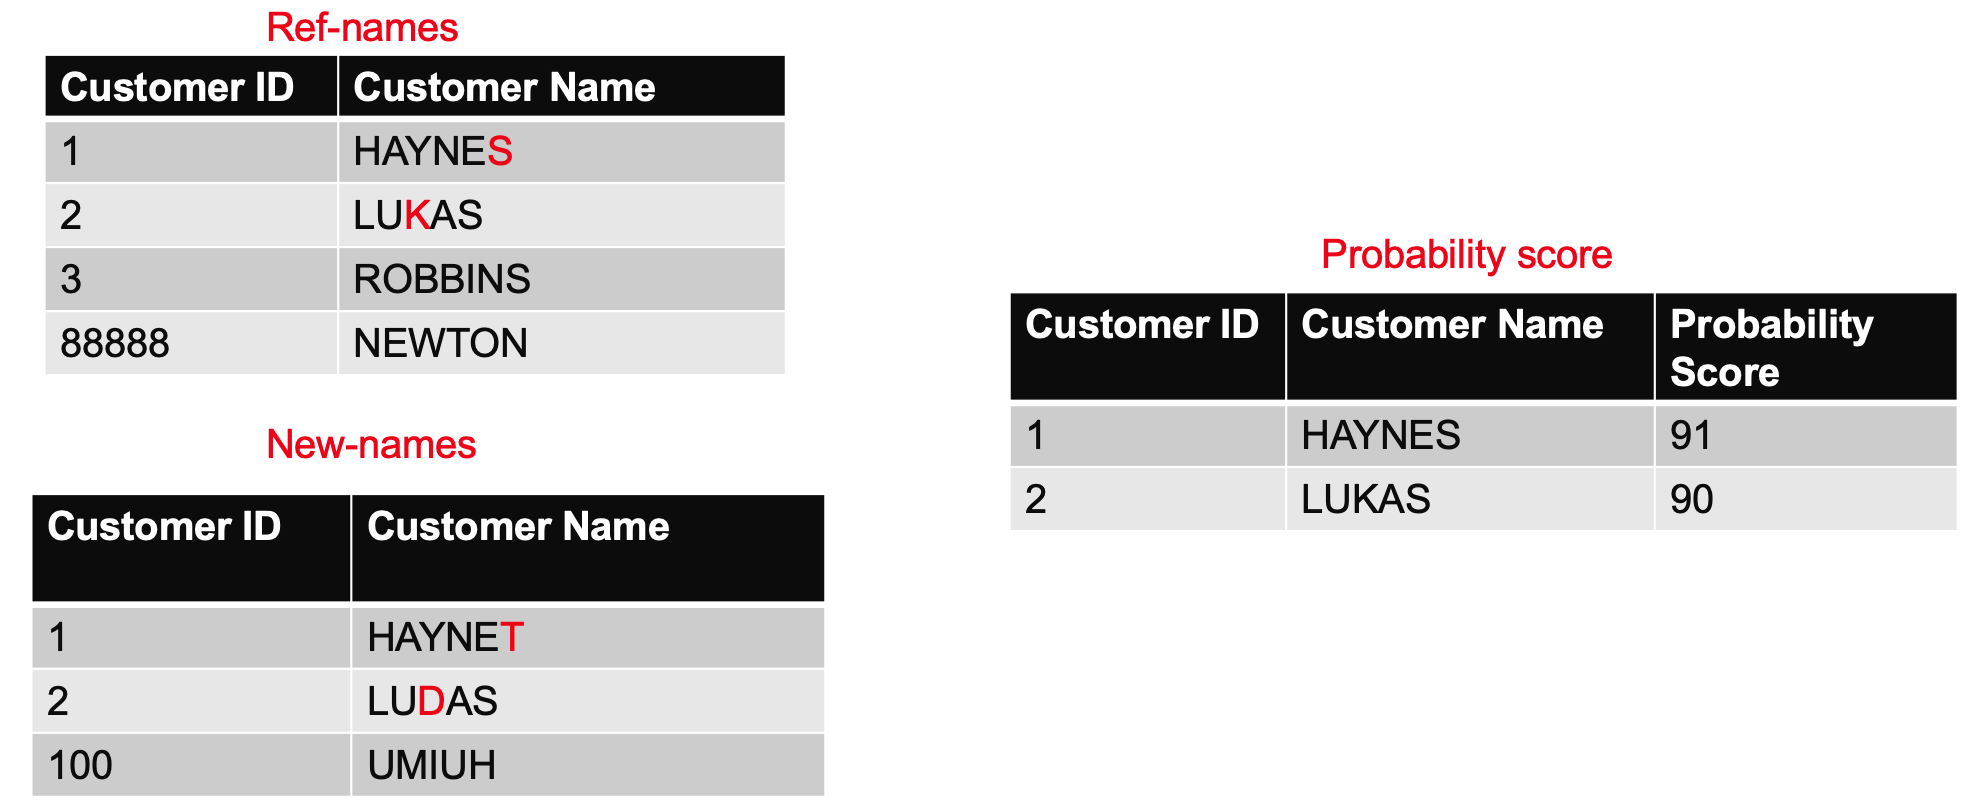

In [4]:
serverRepoLocation = PurePosixPath("/opt/xilinx/apps")
serverDataLocation = serverRepoLocation / PurePosixPath(exampleLocation) / "data"
ref_names_file = serverDataLocation / "ref-names.csv"
new_names_file = serverDataLocation / "new-names.csv"


In [5]:
refNames = {}
line_cnt = 0
with open(ref_names_file) as f:
    for line in f:
        if line_cnt > 0:
            id_name = line.strip().split(',')
            refNames[int(id_name[0])] = id_name[1]
        line_cnt += 1
                

---
#### Prepare TG database
Shows **one-time** preparation of the database. Once done, queries can be repeateadly run as shown in the next Section.
1. [**Load Graph**](#loadg)
 - [Create new graph](#newg)
 - [Create graph schema](#schema)
 - [Load graph data](#loadd)
 - [Install queries](#install)


#### Run Queries on FPGA
Shows **repeatable** use of query to run *accelerated* similarity computation on FPGA
1. [**Compute Fuzzy Match**](#run)

The cells below show how to perform these steps in detail.

### 1. Load Graph <a id="loadg"></a>
---
#### 1.1 Create new graph <a id="newg"></a>
- Connect to TigerGraph server by ommiting graph name. This is needed to establish a valid REST endpoint that will be used to create a new desired graph
- Create new graph by using gsql command and create a new connection with the new graph

In [6]:
# connect to TG server and create graph
graphName = f'xgraph_{userName}'   # TG graph name
conn = tg.TigerGraphConnection(host='http://' + hostName, graphname='', username=userName, password=passWord, useCert=False)
print("\n--------- Creating New graph ----------")
print(conn.gsql(f'create graph {graphName}()', options=[]))

# connect to TG server with new graph
print(f'Using graph {graphName}')
conn = tg.TigerGraphConnection(host='http://' + hostName, graphname=graphName, username=userName, password=passWord, useCert=False)


--------- Creating New graph ----------
The graph xgraph_tigergraph is created.
Using graph xgraph_tigergraph


Any command or query will now run on the new graph.

#### 1.2 Create graph schema <a id="schema"></a>
TigerGraph stores graph in the form of vertices that can be associated with other vertices using directed or undirected edges. This is specified in the form of a graph schema. For the purpose of this demo, the schema is already defined as a query file. Load the file, set graph name and run it as gsql commands. 

The user can create schema for their own graph in a similar way. 

In [7]:
print("\n--------- Creating New Schema ----------")
schemaFile = queryFileLocation / "schema.gsql"

with open(schemaFile) as fh:
    qStrRaw = fh.read()
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))


--------- Creating New Schema ----------
Using graph 'xgraph_tigergraph'
The graph xgraph_tigergraph is dropped.
The graph xgraph_tigergraph is created.
The job job_schema_change_local is created.

Current graph version 0
Trying to add vertex ref_names.
Trying to add vertex new_names.
Trying to add vertex dummy_nodes.
Kick off job job_schema_change_local

Graph xgraph_tigergraph update to new version 1
The job job_schema_change_local completes in 10.604 seconds!
The job job_schema_change_local is dropped!


#### 1.3 Load graph data  <a id="loadd"></a>
This step will load the ref-names and new names into the vertices created above 


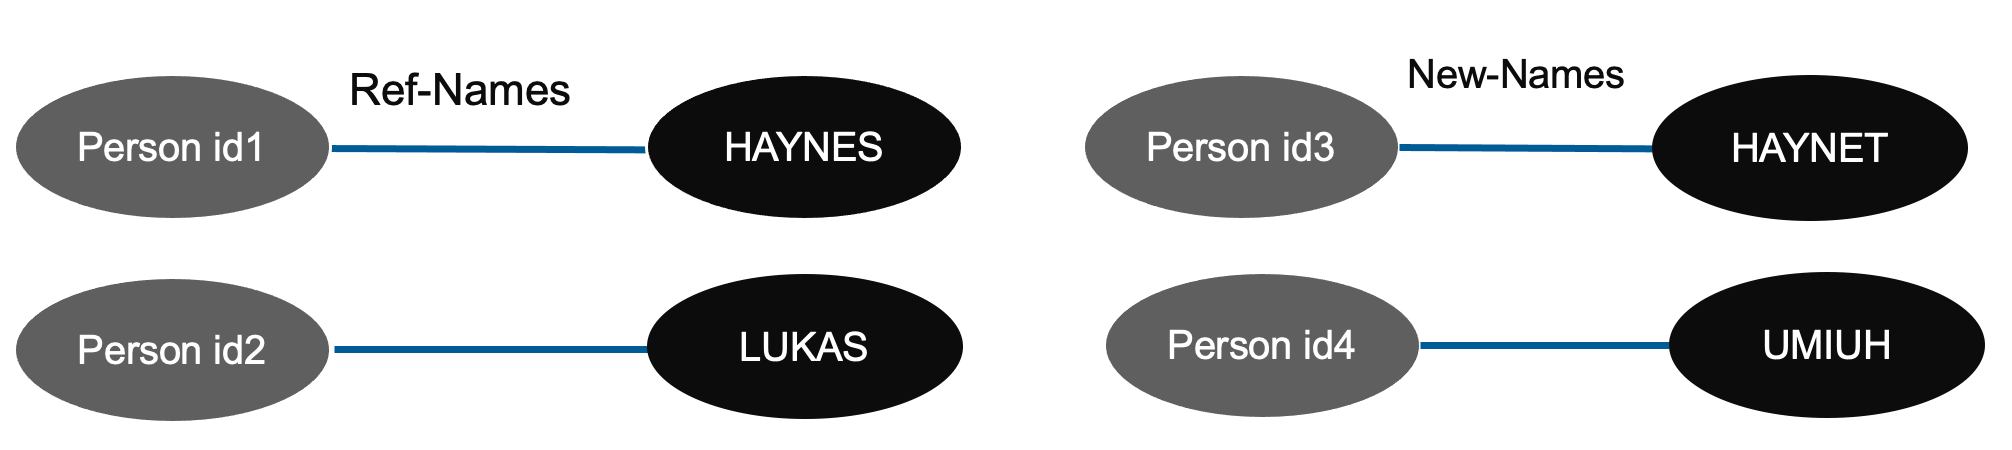

In [8]:
print("\n--------- Loading data into graph ----------")
loadFile = queryFileLocation / "load.gsql"
print(ref_names_file)
with open(loadFile) as fh:
    qStrRaw = fh.read()
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))
    print(conn.gsql(f'USE GRAPH {graphName}\n RUN LOADING JOB load_job USING ref_names_csv="{ref_names_file}", new_names_csv="{new_names_file}"'))
    print(conn.gsql(f"USE GRAPH {graphName}\n DROP JOB load_job"))


--------- Loading data into graph ----------
/opt/xilinx/apps/graphanalytics/integration/Tigergraph-3.x/fuzzymatch/0.2/examples/entity-resolution/data/ref-names.csv
Using graph 'xgraph_tigergraph'
The job load_job is created.



Using graph 'xgraph_tigergraph'
[Tip: Use "CTRL + C" to stop displaying the loading status update, then use "SHOW LOADING STATUS jobid" to track the loading progress again]
[Tip: Manage loading jobs with "ABORT/RESUME LOADING JOB jobid"]
Starting the following job, i.e.
JobName: load_job, jobid: xgraph_tigergraph.load_job.file.m1.1645748231703
Loading log: '/home2/tigergraph/tigergraph/log/restpp/restpp_loader_logs/xgraph_tigergraph/xgraph_tigergraph.load_job.file.m1.1645748231703.log'

Job "xgraph_tigergraph.load_job.file.m1.1645748231703" loading status
[RUNNING] m1 ( Finished: 0 / Total: 2 )
Job "xgraph_tigergraph.load_job.file.m1.1645748231703" loading status
[FINISHED] m1 ( Finished: 2 / Total: 2 )
[LOADED]
+-----------------------------------------------

#### 1.4 Install queries <a id="install"></a>
The cosine similarity application functionality is implemented using gsql queries and UDF functions. The queries need to be installed before running.

The user can create their own queries and install them instead. If user writes their own UDFs, they will need to be compilled and opened as a TigerGraph Plugin (this is not covered in the scope of this demo).

In [9]:
print("\n--------- Installing Queries ----------")
baseQFile = queryFileLocation / "base.gsql"
clientQFile = queryFileLocation / "entity_resolution.gsql"

with open(baseQFile) as bfh, open(clientQFile) as cfh:
    print("installing base queries ...")
    qStrRaw = bfh.read()
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))
    
    print("\ninstalling entity resolution queries ...")
    qStrRaw = cfh.read()
    qStr = qStrRaw.replace('@graph', graphName)
    print(conn.gsql(qStr))


--------- Installing Queries ----------
installing base queries ...
Using graph 'xgraph_tigergraph'
Query insert_dummy_nodes could not be found.
The query insert_dummy_nodes has been added!
Start installing queries, about 1 minute ...
insert_dummy_nodes query: curl -X GET 'http://127.0.0.1:9000/query/xgraph_tigergraph/insert_dummy_nodes?numNodes=VALUE'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.


installing entity resolution queries ...
Using graph 'xgraph_tigergraph'
Query entity_resolution_tg could not be found.
Query entity_resolution_alveo could not be found.
Query entity_resolution_perf_alveo could not be found.
Query entity_resolution_cpu could not be found.
Query entity_resolution_loadvec_alveo could not be found.
The query entity_resolution_tg has been added!
The query entity_resolution_cpu has been added!
The query entity_resolution_perf_alveo has been added!
The query entity_resolution_loadvec_alveo has been added!
The query entity_resolution_alveo h

This completes the TigerGraph database and consine similiarity compute preparation. We can now run as many similarity queries as we want. 

### Compute FuzzyMatch <a id="run"></a>
---
For the purpose of this demo, we get the first 100 patients and choose one at random. Patients are represented by an ID which is passed to the match query.

In [10]:
print('Running Query on CPU...')

tStart = time.perf_counter()
result = conn.runInstalledQuery('entity_resolution_tg', timeout=240000000)
tDuration = 1000*(time.perf_counter() - tStart)
executionTimeCpu = tDuration
for res in result:
    for k in res:
        print(k,":", res[k])

print(f"\nRound Trip time: {tDuration:.2f} msec")

Running Query on CPU...
ComputationTechnique : TigerGraph CPU
PeakVirtualMemoryInGB : 2.68529
PeakResidentMemoryInGB : 0.32682
ExecTimeInMs : 387
RefNamesSize : 842
TargetPersonsSize : 259
AvergeTimePerPersonInMs : 1.49421

Round Trip time: 414.97 msec


In [11]:
print('Running Query on FPGA...')
result = conn.runInstalledQuery('entity_resolution_loadvec_alveo', timeout=240000000)
tStart = time.perf_counter()
result = conn.runInstalledQuery('entity_resolution_alveo', timeout=240000000)
tDuration = 1000*(time.perf_counter() - tStart)
executionTimeFPGA = tDuration
#for top_k in result[0]['TopKMatch']:
#    print(top_k)

print(f"\nRound Trip time: {tDuration:.2f} msec")


Running Query on FPGA...

Round Trip time: 11.34 msec


In [12]:
newNameIdx = 0
newNames = []
totalMatches = 0
for res in result:
    if 'NewNames' in res:
        for name in res['NewNames']:
            newNames.append(name)
                   
    if 'TopKMatch' in res:
        for top_k in res['TopKMatch']:
            if len(top_k) > 0:
                print('New name:', newNames[newNameIdx], 'Ref name:', refNames[top_k[0][0]], 'Score:', top_k[0][1])
                totalMatches += 1
                
            newNameIdx += 1
            
print('INFO: Total number of matches:', totalMatches)            

New name: FENSTERMACHFR Ref name: FENSTERMACHER Score: 93
New name: MERRZWEATHER Ref name: MERRYWEATHER Score: 92
New name: MIERZEJEWVKI Ref name: MIERZEJEWSKI Score: 92
New name: BROCKEMMEYER Ref name: BROCKELMEYER Score: 92
New name: BODENSTFINER Ref name: BODENSTEINER Score: 92
New name: DEMAFONTAINE Ref name: DELAFONTAINE Score: 92
New name: RIEMEPSCHNEID Ref name: RIEMENSCHNEID Score: 93
New name: PONGKHAMSINH Ref name: PONGKHAMSING Score: 92
New name: BIANCANIFLLO Ref name: BIANCANIELLO Score: 92
New name: HATZENBUILER Ref name: HATZENBUHLER Score: 92
New name: CLINKJNBEARD Ref name: CLINKINBEARD Score: 92
New name: PVLVERMACHER Ref name: PULVERMACHER Score: 92
New name: BBGHDASARIAN Ref name: BAGHDASARIAN Score: 92
New name: LICHUENBERGER Ref name: LICHTENBERGER Score: 93
New name: BLOONINGDALE Ref name: BLOOMINGDALE Score: 92
New name: NANTCNAPIBUL Ref name: NANTANAPIBUL Score: 92
New name: PLTSENBARGER Ref name: PITSENBARGER Score: 92
New name: FUNDEOBERGER Ref name: FUNDENBER

Feel free to play with the query!

#### Thanks for your time!

In [13]:
print('Acceleration Factor on Alveo', executionTimeCpu/executionTimeFPGA)

Acceleration Factor on Alveo 36.57983668191131
